# 1. Data Preprocessing


In [1]:
from google.colab import auth
auth.authenticate_user()

In [2]:
!echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
!apt -qq update
!apt -qq install gcsfuse

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2537  100  2537    0     0  76878      0 --:--:-- --:--:-- --:--:-- 79281
OK
65 packages can be upgraded. Run 'apt list --upgradable' to see them.
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  gcsfuse
0 upgraded, 1 newly installed, 0 to remove and 65 not upgraded.
Need to get 10.8 MB of archives.
After this operation, 23.1 MB of additional disk space will be used.
Selecting previously unselected package gcsfuse.
(Reading database ... 160706 files and directories currently installed.)
Preparing to unpack .../gcsfuse_0.35.0_amd64.deb ...
Unpacking gcsfuse (0.35.0) ...
Setting up gcsfuse (0.35.0) ...


In [3]:
!mkdir data
!gcsfuse --implicit-dirs pose-estimation-datasets ./data/

2021/05/18 05:21:14.132553 Using mount point: /content/data
2021/05/18 05:21:14.139519 Opening GCS connection...
2021/05/18 05:21:14.394326 Mounting file system "pose-estimation-datasets"...
2021/05/18 05:21:14.434979 File system has been successfully mounted.


In [26]:
import glob
import scipy.io as sio
import matplotlib.pyplot as plt
import cv2
import numpy as np

image_file_names = [g for g in glob.glob("data/AFLW2000/*.jpg")]
annotation_file_names = [g for g in glob.glob("data/AFLW2000/*.mat")]


images = []
annotations = []


subset = 2000

for i, (iname, aname) in enumerate(zip(image_file_names[:subset], annotation_file_names[:subset])):
    print("Reading image", i ,"...")
    # Read image in BGR format
    im = cv2.imread(iname)

    # Read points in, use only selected landmarks
    points = sio.loadmat(aname)["pt2d"]                                             # Read in points
    POINT_INDICES = [7, 10, 14]                                                     # Center left eye, center right eye, center nose
    x, y = np.take(points[0], POINT_INDICES), np.take(points[1], POINT_INDICES)     # Select only chosen points

    # Append input image and output points to respective lists
    images.append(im)
    pts_out = np.vstack((x ,y))
    annotations.append(pts_out)

    # Plot points and images in BGR
    # plt.figure()
    # plt.scatter(x, y, marker="1")
    # plt.imshow(im[:,:,::-1])



images, annotations = np.array(images), np.array(annotations)
print(images.shape, annotations.shape)


Reading image 0 ...
Reading image 1 ...
Reading image 2 ...
Reading image 3 ...
Reading image 4 ...
Reading image 5 ...
Reading image 6 ...
Reading image 7 ...
Reading image 8 ...
Reading image 9 ...
Reading image 10 ...
Reading image 11 ...
Reading image 12 ...
Reading image 13 ...
Reading image 14 ...
Reading image 15 ...
Reading image 16 ...
Reading image 17 ...
Reading image 18 ...
Reading image 19 ...
Reading image 20 ...
Reading image 21 ...
Reading image 22 ...
Reading image 23 ...
Reading image 24 ...
Reading image 25 ...
Reading image 26 ...
Reading image 27 ...
Reading image 28 ...
Reading image 29 ...
Reading image 30 ...
Reading image 31 ...
Reading image 32 ...
Reading image 33 ...
Reading image 34 ...
Reading image 35 ...
Reading image 36 ...
Reading image 37 ...
Reading image 38 ...
Reading image 39 ...
Reading image 40 ...
Reading image 41 ...
Reading image 42 ...
Reading image 43 ...
Reading image 44 ...
Reading image 45 ...
Reading image 46 ...
Reading image 47 ...
Re

In [ ]:

annotations = annotations.reshape(2000, 6)
print(images.shape, annotations.shape)

np.save("images.npy", images)
np.save("annotations.npy", annotations)

# 2. Data Loading

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch import optim
from torch.utils.data import TensorDataset, DataLoader

images, annotations = torch.Tensor(np.load("images.npy")), torch.Tensor(np.load("annotations.npy"))
print(images.shape, annotations.shape)
images /= 255
images -= 0.5

annotations /= 450



my_dataset = TensorDataset(images, annotations)
my_dataloader = DataLoader(my_dataset, batch_size=10)



torch.Size([2000, 450, 450, 3]) torch.Size([2000, 6])


In [3]:
class CNNModel(nn.Module):

    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 11)
        self.conv2 = nn.Conv2d(8, 16, 5)
        self.conv3 = nn.Conv2d(16, 32, 5)
        self.conv4 = nn.Conv2d(32, 16, 5)
        self.conv5 = nn.Conv2d(16, 8, 5)


        self.fc1 = nn.Linear(800, 100)
        self.fc2 = nn.Linear(100, 10)
        self.fc3 = nn.Linear(10, 6)

    def forward(self, x):     
        
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv4(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv5(x)), (2, 2))


        x = torch.flatten(x, 1)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.sigmoid(self.fc3(x))


        return x
    

In [4]:
epochs = 15
learning_rate = 0.01
weight_decay = 0.001

model = CNNModel()  #making an instance of the network
model = model.cuda()
optim = torch.optim.SGD(model.parameters(), lr = learning_rate, weight_decay=weight_decay)  #model.paramters() gives all the trainable paramters. 
loss_function = nn.MSELoss()



global_train_loss = []

for epoch in range(epochs):
    local_train_loss = []

    for idx, batch in enumerate(my_dataloader):
        # Get inputs, ground truth outputs
        im, pts = batch[0].cuda(), batch[1].cuda()
        # Reorient channels to be before height and width
        im = im.permute(0, 3, 1, 2)
        
        # Feed forward, compute loss
        pts_out = model(im)
        loss = loss_function(pts_out, pts)
        local_train_loss.append(loss.item())

        # Backprop, step optimizer
        optim.zero_grad()
        loss.backward()  
        optim.step()
    
    print(local_train_loss)
    global_train_loss.append(sum(local_train_loss)/len(local_train_loss))

    if epoch%1==0:
        print("Epoch : [{}/{}], Train loss: {}, Val loss: {}".format(epoch, epochs, global_train_loss[-1], 0))


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[0.03252926468849182, 0.033052798360586166, 0.007837728597223759, 0.008116485550999641, 0.008074081502854824, 0.015650032088160515, 0.025225894525647163, 0.04136700928211212, 0.032893914729356766, 0.05804631859064102, 0.0334797166287899, 0.06629423052072525, 0.008899223059415817, 0.009036014787852764, 0.01661081239581108, 0.050008729100227356, 0.03374385088682175, 0.03979763016104698, 0.03260055184364319, 0.008000599220395088, 0.04207780584692955, 0.06609571725130081, 0.024287214502692223, 0.02488984726369381, 0.041254863142967224, 0.0464349202811718, 0.025124741718173027, 0.025322964414954185, 0.08329768478870392, 0.04902804642915726, 0.025036467239260674, 0.056396543979644775, 0.008274128660559654, 0.023784924298524857, 0.033014703541994095, 0.01639913208782673, 0.0167702529579401, 0.025604896247386932, 0.03258592635393143, 0.007551167160272598, 0.008110168389976025, 0.008081442676484585, 0.024886831641197205, 0.016742734238505363, 0.03143921494483948, 0.024604547768831253, 0.0073649

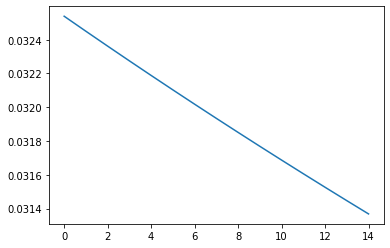

In [36]:
import matplotlib.pyplot as plt

torch.save(model.state_dict(), "model.pth")


plt.figure()
plt.plot(global_train_loss)

torch.Size([2000, 450, 450, 3]) torch.Size([2000, 6])
torch.Size([1, 6])
(3,) (3,) (3,) (3,)
(array([182.05882, 279.47058, 222.29411], dtype=float32), array([199.     , 208.52942, 286.88235], dtype=float32)) (array([200.93561, 215.07509, 256.27896], dtype=float32), array([222.2053 , 204.50642, 210.96043], dtype=float32))
torch.Size([1, 6])
(3,) (3,) (3,) (3,)
(array([ -1.     , 247.52173, 184.91304], dtype=float32), array([452.00003, 224.04347, 263.17392], dtype=float32)) (array([200.95656, 215.0533 , 256.28287], dtype=float32), array([222.23854, 204.51085, 210.98114], dtype=float32))
torch.Size([1, 6])
(3,) (3,) (3,) (3,)
(array([196.70808, 245.10994, 196.51724], dtype=float32), array([242.36378, 235.4983 , 274.10345], dtype=float32)) (array([200.933  , 215.1309 , 256.31235], dtype=float32), array([222.2044 , 204.57674, 210.98434], dtype=float32))
torch.Size([1, 6])
(3,) (3,) (3,) (3,)
(array([176.73964, 251.29584, 222.00592], dtype=float32), array([232.6568 , 211.35503, 291.2367 ], d

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


(array([186.79356, 267.70367, 219.42398], dtype=float32), array([217.92564, 214.59601, 256.71588], dtype=float32)) (array([200.9232 , 215.07506, 256.29092], dtype=float32), array([222.25978, 204.4997 , 210.9824 ], dtype=float32))
torch.Size([1, 6])
(3,) (3,) (3,) (3,)
(array([189.05971, 265.1791 , 222.64178], dtype=float32), array([224.8806 , 224.8806 , 253.98508], dtype=float32)) (array([200.94801, 215.0655 , 256.30716], dtype=float32), array([222.27408, 204.49316, 211.02187], dtype=float32))
torch.Size([1, 6])
(3,) (3,) (3,) (3,)
(array([178.78632, 242.77556, 202.30669], dtype=float32), array([236.54956, 208.87856, 270.4466 ], dtype=float32)) (array([200.92682, 215.03572, 256.30777], dtype=float32), array([222.33432, 204.42128, 211.0385 ], dtype=float32))
torch.Size([1, 6])
(3,) (3,) (3,) (3,)
(array([185.72131,  -1.     , 224.37704], dtype=float32), array([217.29507, 452.00003, 264.2131 ], dtype=float32)) (array([200.95119, 215.11566, 256.35983], dtype=float32), array([222.27327, 20

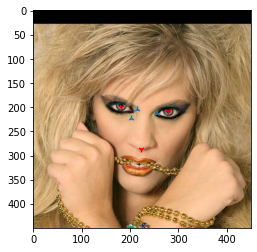

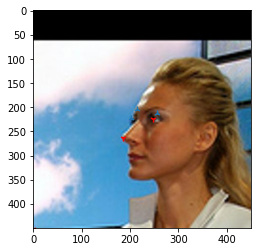

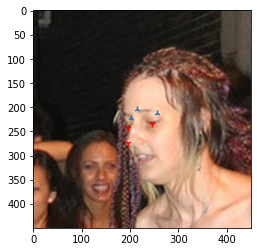

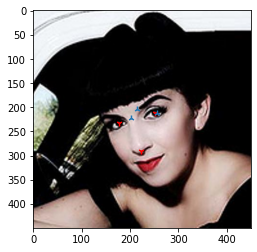

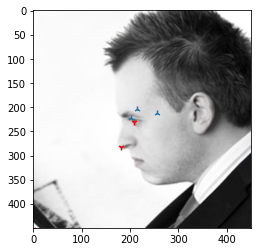

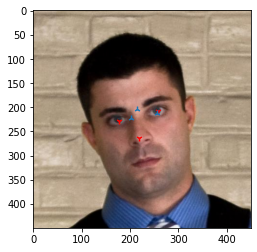

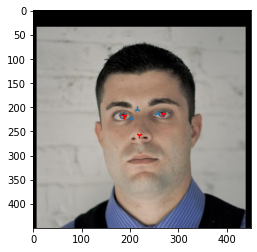

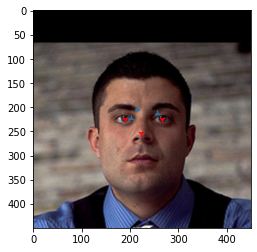

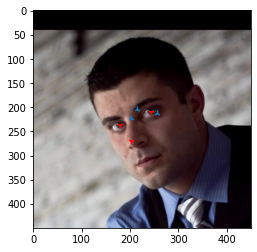

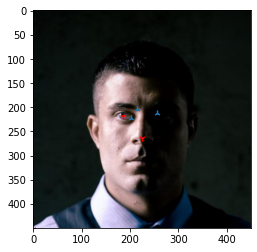

In [35]:
import matplotlib.pyplot as plt


subset = 10

print(images.shape, annotations.shape)

model.eval()
with torch.no_grad():
    for im, pts in zip(images[:subset], annotations[:subset]):
        im_tensor, pts_tensor = torch.unsqueeze(im, 0), torch.unsqueeze(pts, 0)
        im_tensor, pts_tensor = torch.Tensor(im_tensor).cuda(), torch.Tensor(pts_tensor).cuda()
        # # Reorient channels to be before height and width

        im_tensor = im_tensor.permute(0, 3, 1, 2)


        pts_out = model(im_tensor)
        x_gt, y_gt = pts_tensor[0][:3].cpu().numpy(), pts_tensor[0][3:].cpu().numpy()
        x_pred, y_pred = pts_out[0][:3].cpu().numpy(), pts_out[0][3:].cpu().numpy()

        x_gt, y_gt, x_pred, y_pred = x_gt * 450, y_gt * 450, x_pred * 450, y_pred * 450



        plt.figure()
        plt.scatter(x_gt, y_gt, marker="1", color="r")
        plt.scatter(x_pred, y_pred, marker="2")

        print((x_gt, y_gt), (x_pred, y_pred))
        plt.imshow(((im.cpu().numpy()[:,:,::-1] + 0.5) * 255).astype(np.uint8))


